## How Many Reads Do You Need?

Metagenomics uses short-read DNA sequencing to measure the microbes in a sample. Typically, short-read DNA comes in pairs of sequences which are 100-200 base pairs long each. These reads are long enough to be matched to a catalog of genes or genomes allowing researchers to estimate the taxonomic composition of their sample. Unlike amplicon sequencing (which only sequences a particular marker gene) metagenomics allows more specific classification and accurate estimates of the genetic composition of a sample.

Though powerful short read DNA is expensive. Even with state of the art Illumina machines it can cost upward of several hundred dollars just for a few million reads. So the question naturally arises how many reads do you actually need?

There's no simple answer to this question in metagenomics: it will always depend on the parameters of your experiment and what you're trying to detect. If cost were not a factor there would never be a downside to more reads. However, since resources are constrained in the real world we can estimate how many reads we need to accurately detect low abundance taxa in our sample.

### Setup the notebook

In [50]:
from random import random, randrange
from math import log
import pandas as pd

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [8]:
%%R

library(ggplot2)

### Detecting Low Abundance Microbes

We can model the chance of detecting a low abundance microbe in our samples based on a given read depth. Let $p_i$ be the proportion of DNA unique to taxa $i$ in our sample. We can then model the number of reads we need to draw $R$ before drawing $n$ reads from taxa $i$ as a negative binomial distribution.

$ R \sim NB(n, p_i) $
$ Pr(R = r) = {r + n - 1 \choose r} p_i^n (1 - p_i)^{r} $

If we assume we must detect two reads from a given taxa to detect that taxa we can say.

$ Pr(R = r) = (r + 1) (1 - p_i)^{r} p_i^2 $

Using the CDF we can state the probability that $R$ is less than a specified number of reads $r$.

$
    Pr(R \leq r) = \sum_{j=2}^{r}  
        (j + 1) (1 - p_i)^j (p_i)^2
$

The proportion of DNA which is uniquely assignable to a specific taxa varies by taxa rank and by clade. However, the typical definition specifies that a species has at least 3\% unique DNA. We can use this to state $p_i$ in terms of the abundance of taxa $i$, $t_i$. 

$ p_i = 0.03 t_i $

We can simulate this process to get an idea of the results. in the code below we simulate 4 taxa at abundances of 1 in 10,000; 1 in 1,000; 1 in 100; and 1 in 10. We then measure how many reads we need to select from an imaginary infinitely deep sample before we would get a certain number of reads that could be specifically assigned to the species.

In [12]:

def drawn_to_hit(n, p_i, proportion_uniq=0.03):
    """Return the number of reads necessary to find n reads from a particular taxa"""
    hits, total = 0, 0
    while hits < n:
        total += 1
        hits += 1 if random() < (proportion_uniq * p_i) else 0
    return total
        
    
NUM_TO_CALL = [1, 2, 4, 8]
ABS_ABUNDS, TOTAL_READS = [1, 10, 100, 1000], 10 * 1000
REL_ABUNDS = [abund / TOTAL_READS for abund in ABS_ABUNDS]
NTRIALS = 10

tbl = []
for _ in range(NTRIALS):
    for n in NUM_TO_CALL:
        for pi in REL_ABUNDS:
            tbl.append([n, pi, drawn_to_hit(n, pi)])

tbl = pd.DataFrame(tbl, columns=['num_hits', 'rel_abund', 'total_reads'])


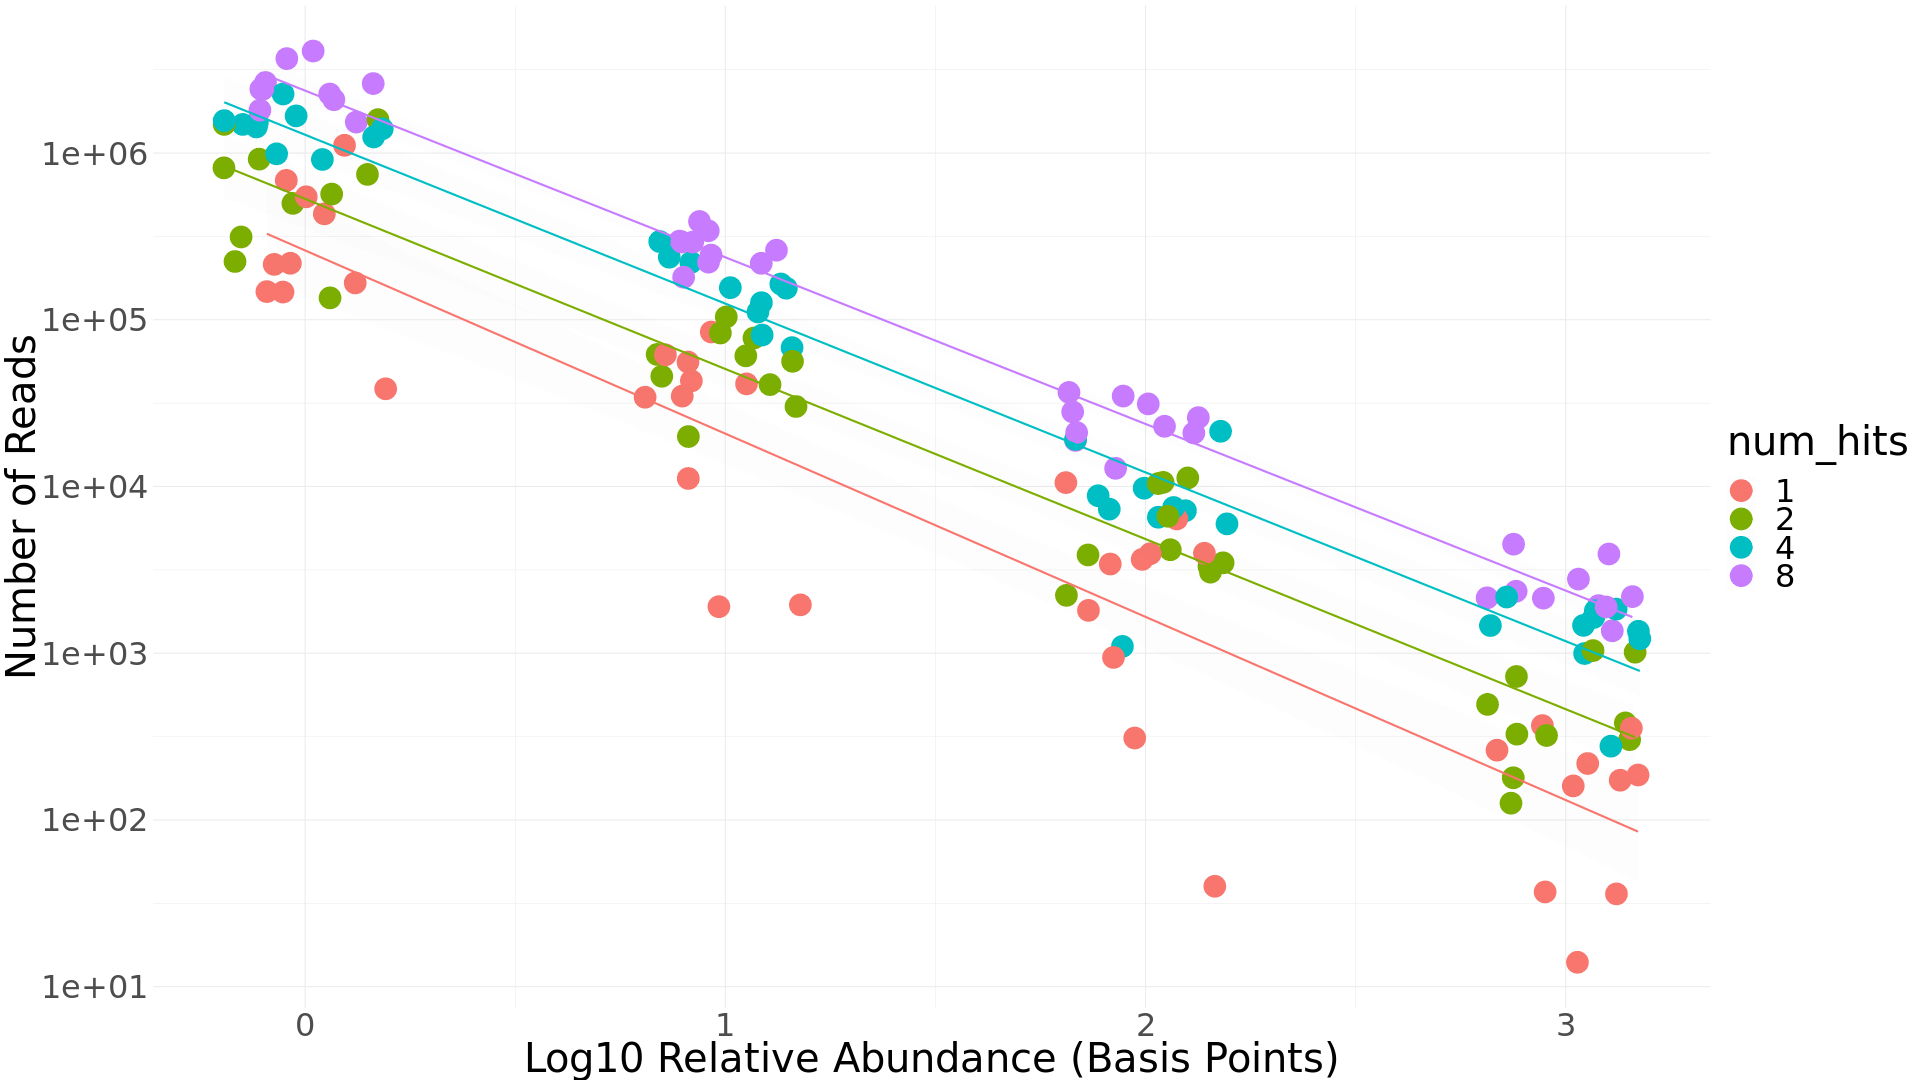

In [13]:
%%R -i tbl  --height 1080 --width 1920
mytbl = tbl
mytbl$num_hits = as.factor(mytbl$num_hits)
mytbl$basis_pts = jitter(log10(10 * 1000 * mytbl$rel_abund))
ggplot(mytbl, aes(x=basis_pts, y=total_reads, color=num_hits)) +
    geom_point(size=10) + 
    geom_smooth(method='lm', alpha=0.01) +
    theme_minimal() + 
    theme(text = element_text(size=40)) +
    scale_y_log10(breaks=c(10, 100, 1000, 10000, 100000, 1000000, 10000000)) +
    xlab('Log10 Relative Abundance (Basis Points)') +
    ylab('Number of Reads')

### The Takeaway

With 5,000,000 reads we will nearly always detect species at 1 part in 10,000, even if we require a relatively large number of reads as our minumum threshold of detection.

### The Caveat
However, detection does not mean that we will accurately quantify the abundance of each taxa. Particularly for low abundance taxa we run the risk of misestimating the actual abundance. We can quantify this risk by simulating how many reads we draw from taxa of known abundances. The most important factor here is the expected number of reads from a taxa which is given by the unique proportion of the species, the relative abundance of the species in the sample, and the total number of reads in the sample.

In [44]:
NTRIALS, PROPORTION_UNIQ = 1, 0.03

abs_abunds = [1000, 10 * 1000, 100 * 1000]
num_reads = [
    abund * multiplier
    for multiplier in (25, 50, 75, 100)
    for abund in abs_abunds
]
rel_abunds = [abund / (1000 * 1000) for abund in abs_abunds]

tbl = []
for _ in range(NTRIALS):
    for rel_abund in rel_abunds:
        for nreads in num_reads:
            expected = PROPORTION_UNIQ * nreads * rel_abund
            #if expected < 0.1:
                #continue  # do not bother with very low abundance
            observed = 1 / (1000 * 1000 * 1000)  # pseudocount
            for _ in range(nreads):
                if random() < (PROPORTION_UNIQ * rel_abund):
                    observed += 1
            
            tbl.append([rel_abund, nreads, expected, observed, observed / expected])

tbl = pd.DataFrame(
    tbl,
    columns=['rel_abund', 'reads_in_sample', 'expected_reads', 'observed_reads', 'ratio']
)


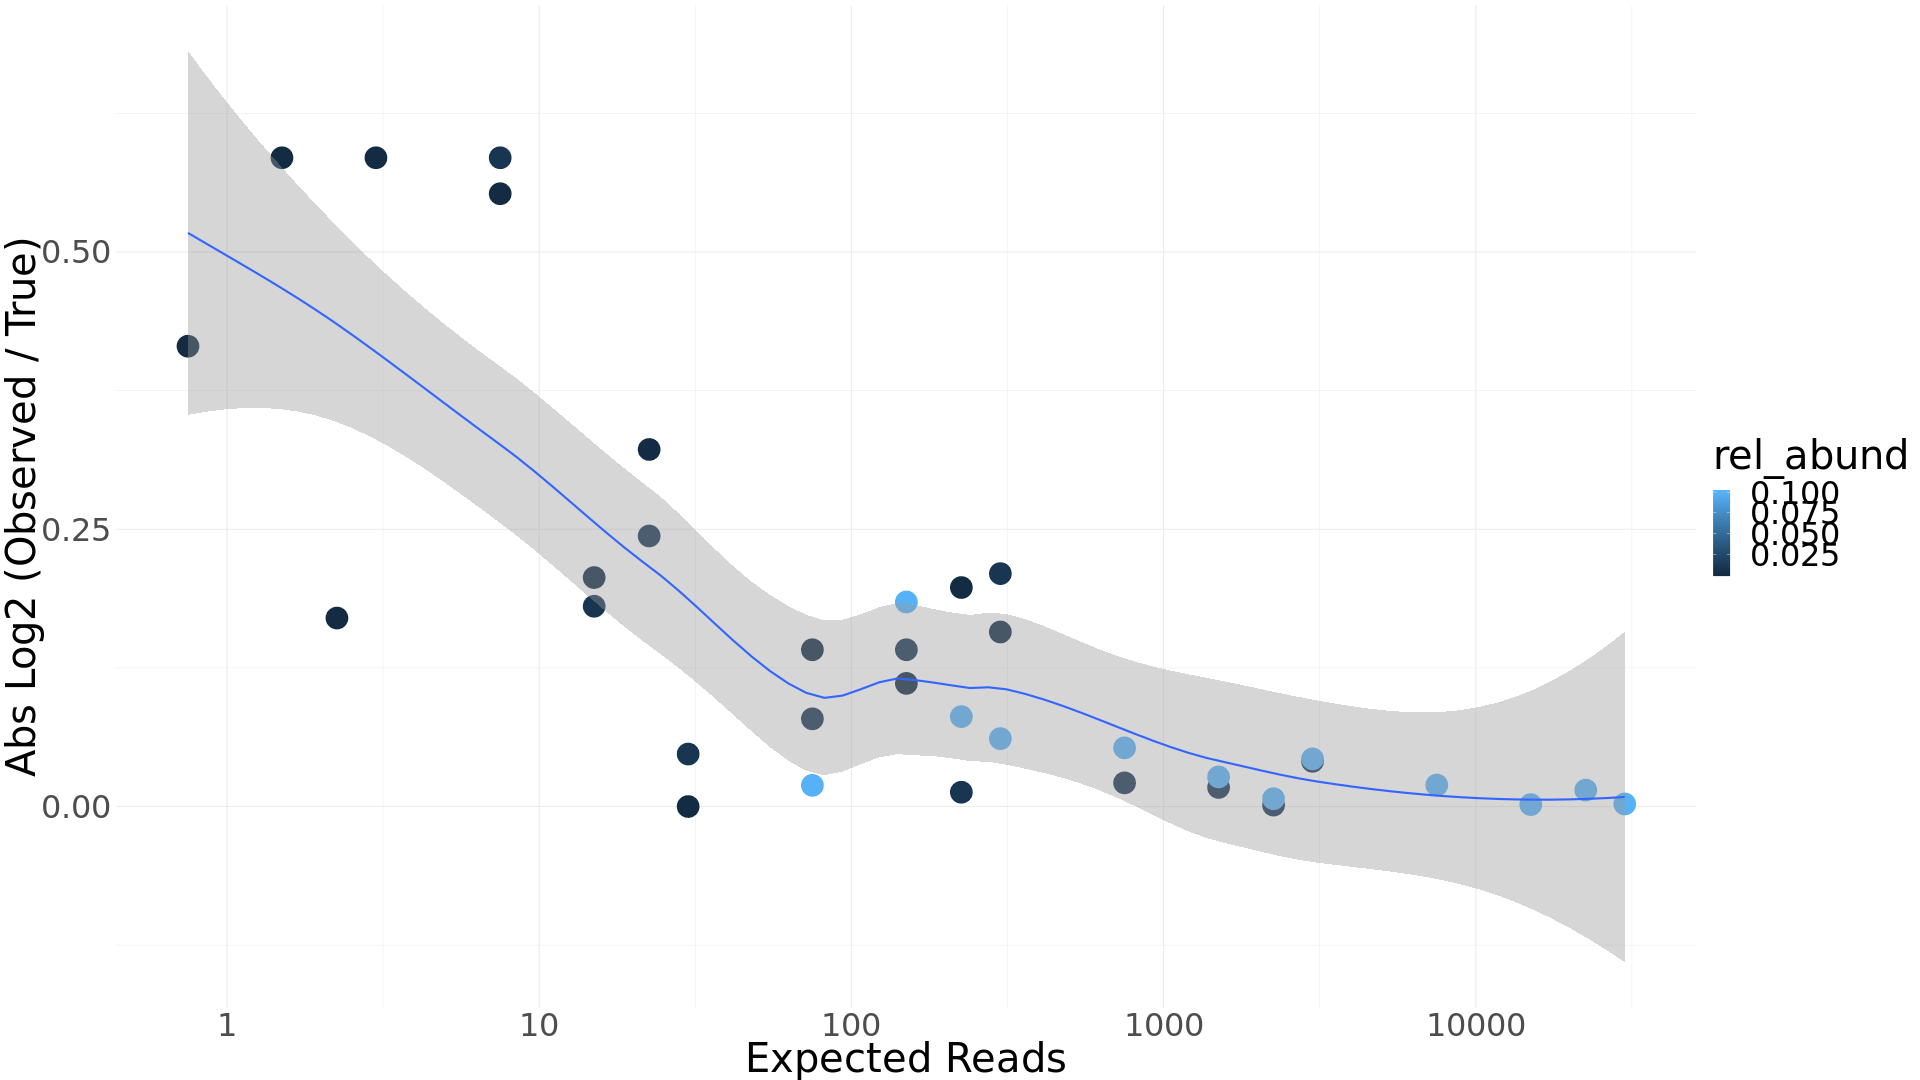

In [49]:
%%R -i tbl  --height 1080 --width 1920

tbl$lr = abs(log2(tbl$ratio))
ggplot(tbl, aes(x=expected_reads, y=lr)) +
    geom_point(size=10, aes(color=rel_abund)) + 
    scale_x_log10(breaks=c(1, 10, 100, 1000, 10000, 100000)) +
    geom_smooth(method='loess') +
    theme_minimal() + 
    theme(text = element_text(size=40)) +
    xlab('Expected Reads') +
    ylab('Abs Log2 (Observed / True)')

Once we have about 100 expected reads our observed abundance starts to line up with the actual abundance. With 10 expected reads or fewer the error becomes extreme.

There is also an issue with dropout. If a species is low abundance we may miss it completely. We can simulate the chance of missing a taxa of aparticular relative abundance. 

In [59]:

NUM_TAXA = [10, 100, 1000, 10 * 1000]
READ_DEPTH = [10 * 1000, 100 * 1000, 1000 * 1000, 5 * 1000 * 1000, 10 * 1000 * 1000]
NTRIALS = 3
DETECT=[1,2,4,8]

def sim_seq(read_depth, num_taxa, proportion_uniq=0.03, detect=2):
    taxa = {}
    for _ in range(read_depth):
        if random() < proportion_uniq:
            taxon = randrange(num_taxa)
            taxa[taxon] = 1 + taxa.get(taxon, 0)
    taxa = [val / read_depth for val in taxa.values() if val >= detect]
    num_missing = num_taxa - len(taxa)
    taxa += [0] * num_missing
    taxa_frac = proportion_uniq / num_taxa
    l1 = sum([abs(val - taxa_frac) for val in taxa])
    return num_missing, l1

tbl = []
for _ in range(NTRIALS):
    for read_depth in READ_DEPTH:
        for num_taxa in NUM_TAXA:
            for detect in DETECT:
                num_missing, l1 = sim_seq(read_depth, num_taxa, detect=detect)
                tbl.append([read_depth, num_taxa, detect, num_missing, l1])

tbl = pd.DataFrame(
    tbl,
    columns=['read_depth', 'num_taxa', 'detect', 'num_missing', 'l1_dist']
)


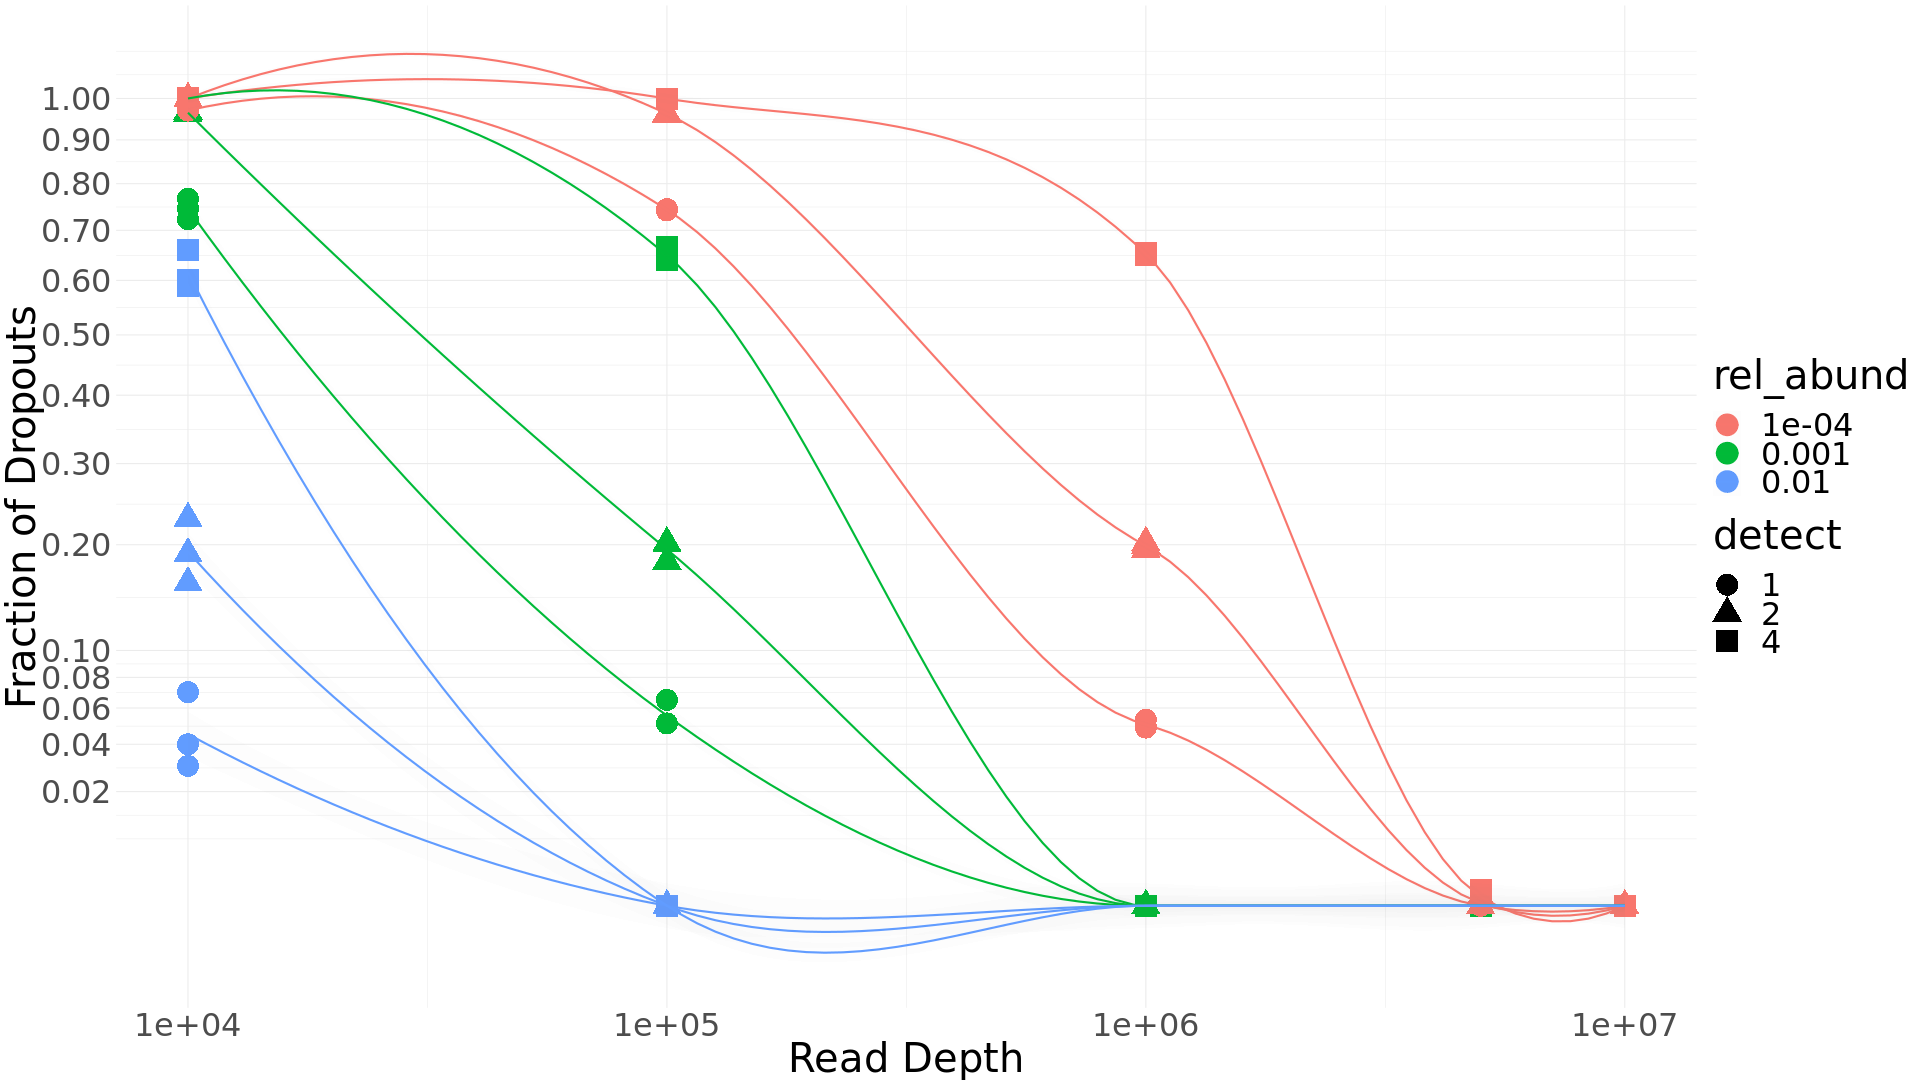

In [65]:
%%R -i tbl  --height 1080 --width 1920

mytbl = tbl[tbl$num_taxa >= 100 & tbl$detect <=4,]
mytbl$rel_abund = 1 / mytbl$num_taxa
mytbl$frac_missing = mytbl$num_missing / mytbl$num_taxa
mytbl$detect = as.factor(mytbl$detect)
mytbl$num_taxa = as.factor(mytbl$num_taxa)
mytbl$rel_abund = as.factor(mytbl$rel_abund)
ggplot(mytbl, aes(x=read_depth, y=frac_missing, color=rel_abund, shape=detect)) +
    geom_point(size=10) + 
    geom_smooth(method='loess', alpha=0.01) +
    theme_minimal() + 
    theme(text = element_text(size=40)) +
    #scale_y_log10(breaks=c(10, 100, 1000, 10000)) +
    scale_y_sqrt(breaks=c(1:4/50, 1:10/10)) +
    scale_x_log10(breaks=c(10000,100000,1000000,10000000)) + 
    xlab('Read Depth') +
    ylab('Fraction of Dropouts')

### Takeaway

If we set 2 reads as the minimum detection threshold A 5M read sample will be missing very few of its (1 / 10,000) abundance species but a 1M read sample will be missing ~20% of these taxa.

We can take this further and plot the distance between simulated samples that are known to have the same actual composition. 

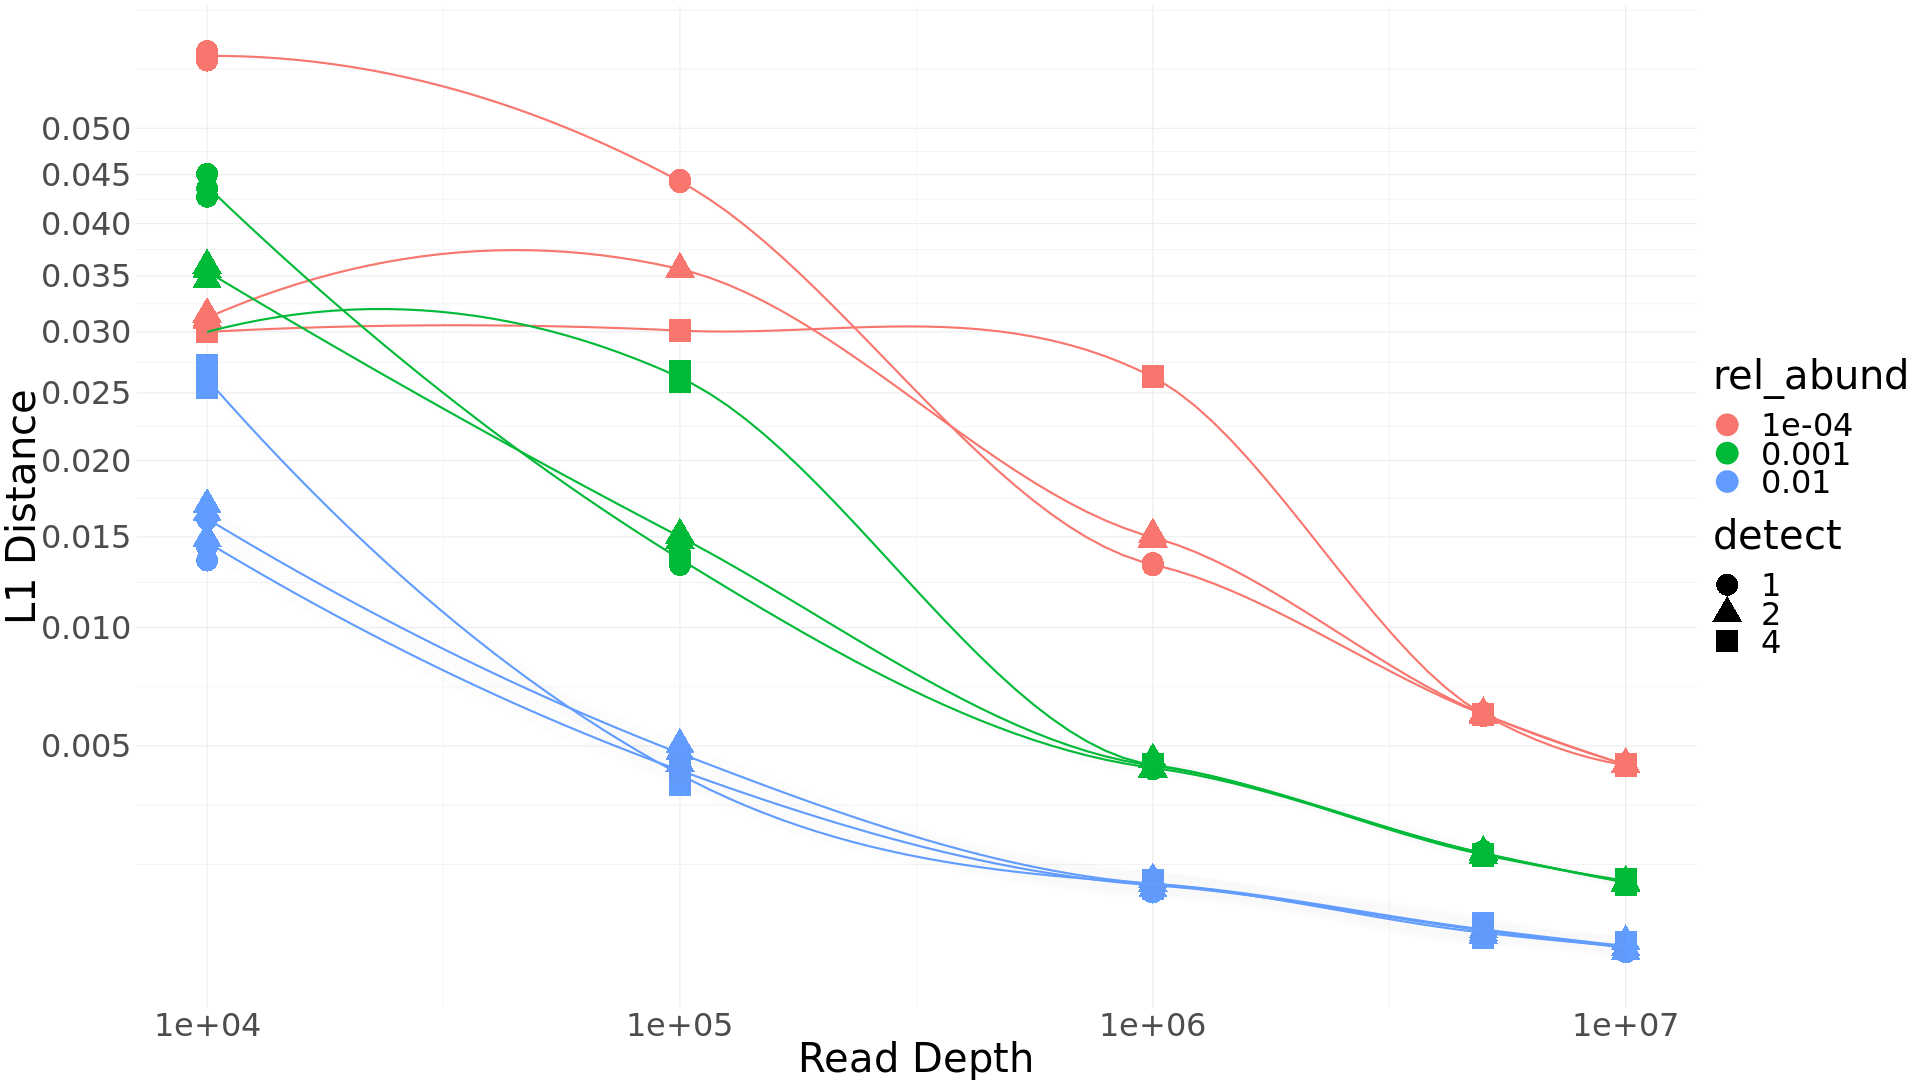

In [66]:
%%R -i tbl  --height 1080 --width 1920
mytbl = tbl[tbl$num_taxa >= 100 & tbl$detect <=4,]
mytbl$rel_abund = 1 / mytbl$num_taxa
mytbl$frac_missing = mytbl$num_missing / mytbl$num_taxa
mytbl$detect = as.factor(mytbl$detect)
mytbl$num_taxa = as.factor(mytbl$num_taxa)
mytbl$rel_abund = as.factor(mytbl$rel_abund)
ggplot(mytbl, aes(x=read_depth, y=l1_dist, color=rel_abund, shape=detect)) +
    geom_point(size=10) + 
    geom_smooth(method='loess', alpha=0.01) +
    theme_minimal() + 
    theme(text = element_text(size=40)) +
    scale_y_sqrt(breaks=c(1:10/200)) +
    scale_x_log10(breaks=c(10000,100000,1000000,10000000)) + 
    xlab('Read Depth') +
    ylab('L1 Distance')

This is a little fuzzier because real microbiomes are not even abundance (this is a worst case) but the rough takeaway is that two 5M read microbiomes within an L1 distance of 0.01 cannot be distinguished.

### Final notes

To effectively detect taxa that occur at one part in 10,000 in a sample should have 5,000,000 reads or more. For low abundance taxa, analyses should distinguish between abundances that can merely be detected and abundances that can be reliably estimated.